## 확률론적 선형회귀모형

- 부트스트래핑 (Bootstrapping)
- 가정
- MLE(Maximum Likelihood Estimation)
- 잔차의 분포
- 회귀 계수의 표준 오차
- 단일 계수 t-검정 (Single Coefficient t-test)
- F - 검정 (Loss-of-Fit 검정)

---

### 00. Setting

In [1]:
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy as sp
import seaborn as sns
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


---

### 01. 부트스트래핑 (Bootstrapping)

#### 1) 배경

- OLS (결정론적) 방법은 확률론적인 가정없이도 최적의 가중치를 계산할 수 있지만


- 가중치가 어느 정도의 신뢰도 또는 안정성을 가지는지 확인할 수 있는 방법이 없음


- 데이터가 확률 변수로부터 생성된 표본이거나 큰 모집단 중 선택한 표본이라고 가정


- 회귀 분석의 결과는 분석에 사용한 표본에 의존적 


- 추가적인 다른 표본을 얻어서 다시 회귀 분석에 사용한다면 회귀 분석 결과 즉, 가중치 벡터의 값은 달라질 것


- 하지만 현실적으로는 데이터를 추가적으로 얻기가 힘듦, 그래서 부트스트래핑 방법을 사용하게 됨

#### 2) 정의

- 회귀 분석에 사용한 데이터가 달라질때 회귀 분석의 결과가 얼마나 영향을 받는지 알기 위한 방법


- 부트스트래핑 방법에선 기존의 데이터를 재 표본화 (re-sampling) 하는 방법을 선택


- 재표본화는 기존의 $N$개의 데이터에서 다시 $N$개의 데이터를 선택하되 중복 선택도 가능하게 함 (resampling with replacement)

#### 3) 코드

In [2]:
# 자연법칙 데이터 생성
from sklearn.datasets import make_regression

X0, y, coef = make_regression(n_samples=100, n_features=1, noise=20,
                              coef=True, random_state=0)
coef

array(42.38550486)

In [3]:
dfX0 = pd.DataFrame(X0, columns=["X1"])
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(y, columns=["y"])

In [4]:
model = sm.OLS(dfy, dfX)
result = model.fit()

In [5]:
result.params # 실제 데이터와 예측 값이 차이가 있다는 것을 확인

const    -1.628364
X1       42.853356
dtype: float64

In [6]:
# 부트스트래핑 실행
N = 1000
params_c = np.zeros(N)
params_x1 = np.zeros(N)

for i in range(N):
    idx = np.random.choice(len(dfy), len(dfy), replace=True) # replace = 중복 허용
    dfX2 = dfX.iloc[idx, :]
    dfy2 = dfy.iloc[idx]
    r = sm.OLS(dfy2, dfX2).fit()
    params_c[i] = r.params.const
    params_x1[i] = r.params.X1

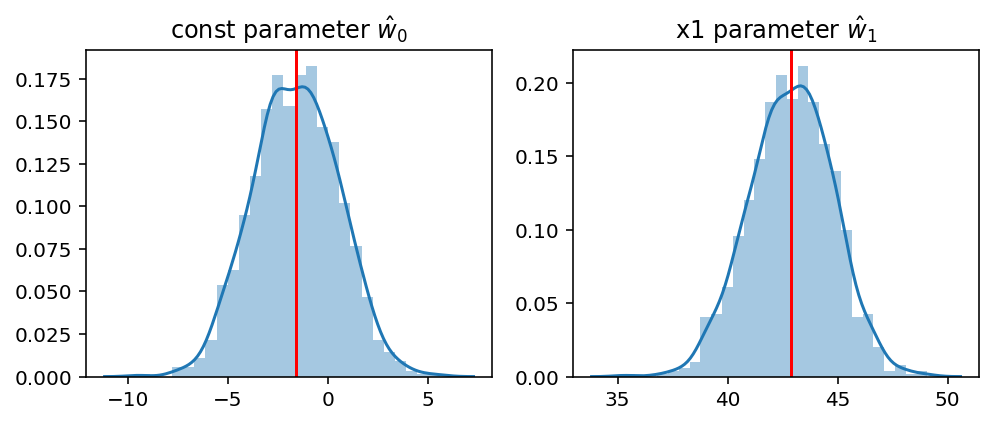

In [7]:
plt.figure(figsize=(8, 3))

ax1 = plt.subplot(121)
sns.distplot(params_c, ax=ax1)
plt.axvline(params_c.mean(), c='r')
plt.title("const parameter $\hat{w}_0$")

ax2 = plt.subplot(122)
sns.distplot(params_x1, ax=ax2)
plt.axvline(params_x1.mean(), c='r')
plt.title("x1 parameter $\hat{w}_1$")
plt.show()

In [8]:
params_c.mean(), params_c.std() # const 벡터 평균과 표준편차

(-1.5954750980823083, 2.119182481691572)

$\rightarrow$ 가중치 중 상수항의 경우 평균은 -1.6이지만 표분 편차가 2보다 크기 때문에 값이 0일 가능성을 배제할 수 없음

In [9]:
params_x1.mean(), params_x1.std() # w1 벡터 평균과 표준편차

(42.89042192077887, 1.8904531348278282)

$\rightarrow$ 확실한건 양의 상관관계 (0은 아님) $\because$ 신뢰구간이 [42.74 - 4, 42.74 + 4] 이기 때문

In [10]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Sun, 04 Mar 2018   Prob (F-statistic):           2.21e-36
Time:                        08:28:16   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6284      2.163     -0.753      0.4

- 보고서의 std err 항목에서 표준 편차의 경우 2.163 이고 마지막의 신뢰 구간(confidence interval)이 -5.920 ~ 2.663 임을 확인
- 부트스트래핑으로 얻은 결과와 유사. 이 결과는 다음에 설명할 확률론적 가정에 의해 계산된 값이다.

---

### 02. 가정

#### 1. 오차(disturbance)의 분포에 대한 가정

#### 1) 선형 정규 분포 가정

(1) 종속 변수 $y$가 독립 변수 $x$의 선형 조합으로 결정되는 기댓값, 분산 $\sigma^2$을 가지는 정규 분포를 따름

$$ y \sim \mathcal{N}(w^Tx, \sigma^2) $$

(2) y의 확률 밀도 함수 (이 식에서 모수 벡터 $\theta=(w, \sigma^2)$)

$$ p(y \mid x, \theta) = \mathcal{N}(y \mid w^Tx, \sigma^2 ) $$

(3) 이 관계식을 오차(disturbance) $ \epsilon_i$ 개념으로 변환

$$ \epsilon_i = y - w^Tx $$

(4) 오차의 확률 밀도 함수

$$ p(\epsilon \mid \theta) = \mathcal{N}(0, \sigma^2 ) $$ <br>

cf ) 유의점 :  x, y 중 그 어느 것도 그 자체로 정규 분포일 필요는 없음

#### 2) 외생성(exogeneity) 가정

(1) 오차 $\epsilon$의 기댓값은 독립 변수 $x$에 상관없이 항상 0이라고 가정

$$ \text{E}[\epsilon \mid x] = 0$$ <br>

(2) 외생성 가정으로부터와 오차 $\epsilon$의 무조건부 기댓값이 0

$$ \text{E}[\epsilon] = 0$$

(3) 같은 가정으로부터 오차 $\epsilon$와 독립 변수 $x$가 무상관 관계라는 것도 증명

$$ \text{E}[\epsilon x] = 0$$

#### 3) 조건부 독립 가정

$i$ 번째 샘플의 오차 $\epsilon_i$와 $j$ 번째 샘플의 오차 $\epsilon_j$의 공분산 값이 $x$와 상관없이 항상 0이라고 가정

$$ \text{Cov}[\epsilon_i, \epsilon_j \mid x] = 0 \;\; (i,j=1,2,\ldots,N)$$ 

$\rightarrow$ 이는 $i$번째 샘플의 오차 $\epsilon_i$와 $j$번째 샘플의 오차 $\epsilon_j$는 서로 독립이라는 가정과 같음

#### 2. 독립 변수에 대한 가정

독립 변수의 공분산 행렬은 Full-rank 이어야 함

$$ \text{rank}(X^TX) = D \;\; (X \in \mathbf{R}^{N \times D})$$

$\rightarrow$ 공분산 행렬이 full rank가 아니면 공분산 행렬의 역행렬이 존재하지 않거나 조건이 나빠져서(ill-conditioned) 올바른 모수 추정이 되지 않음

---

### 03. MLE(Maximum Likelihood Estimation)를 사용한 선형회귀분석

1) Likelihood

$$
\begin{eqnarray}
p(y_{1:N} \,\big|\, x_{1:N}, \theta)
&=& \prod_{i=1}^N \mathcal{N}(y_i \,\big|\, w^T x_i , \sigma^2) \\\\
&=& \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left\{-\frac{(y_i-w^T x_i)^2}{2\sigma^2} \right\}  \\
\end{eqnarray}
$$

2) log-likelihood : 계산을 쉽게하기 위해서

$$
\begin{eqnarray}
\text{LL}  
&=& \log p(y_{1:N} \,\big|\, x_{1:N}, \theta) \\\\
&=& \log \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left\{-\frac{(y_i-w^T x_i)^2}{2\sigma^2} \right\}  \\\\
&=& -\dfrac{1}{2\sigma^2} \sum_{i=1}^N (y_i-w^T x_i)^2 - \dfrac{N}{2} \log{2\pi}{\sigma^2}  \\
\end{eqnarray}
$$



$$\;\therefore \text{LL}  =  -C_1 (y - Xw)^T(y-Xw) - C_0 = -C_1(w^TX^TXw -2 y^TXw + y^Ty) - C_0$$

$$ (C_1 =  -\dfrac{1}{2\sigma^2}\;\;,\;\;C_0 =  \dfrac{N}{2} \log{2\pi}{\sigma^2}) $$


3) $LL$을 최적화하면 OLS와 동일한 결과

$$
\dfrac{\partial}{\partial w} \text{LL} = -C_1 \left( 2X^TX \hat{w} - 2X^Ty \right) = 0
$$

$$
\hat{w} = (X^TX)^{-1}X^T y
$$

4) OLS의 정규 방정식과 같은 형태의 정규 방정식을 얻음

$$ X^TX \hat{w} - X^Ty = 0 $$

$$ X^T(X \hat{w} - y) = X^T(\hat{y} - y) = X^Te = 0 $$

---

### 04. 잔차의 분포

회귀분석에서 생기는 잔차 $e = y - \hat{w}^Tx$ 도 정규 분포를 따름

#### 1) 증명

(1) 확률론적 선형회귀모형의 오차 $\epsilon$와 잔차 $e$의 관계

$$  \hat{y} = X\hat{w} = X (X^TX)^{-1}X^T y = Hy $$

$\rightarrow$ 행렬 $H$은 'Hat 행렬', '프로젝션(projection) 행렬' 또는 '영향도(influence) 행렬' 이라 부르는 대칭 행렬

(2) Hat 행렬의 성질

$$ HH = H $$

(3) Hat 행렬을 이용하여 잔차 표현

$$ e = y - \hat{y}= y - Hy = (I - H) y$$

$\rightarrow$ $M = (I - H)$이라고 정의. 행렬 $M$은 residual 행렬 혹은 rejection 행렬 이라고 함. $H$와 마찬가지로 대칭 행렬

(4) $M$ 행렬의 성질

$$ MM = M $$

(5) $M$ 행렬을 이용하여 잔차 표현

$$ e = My = M (Xw + \epsilon) = MXw + M\epsilon $$

(6) (5) 결과를 정규 방정식에 대입

$$
X^Te = X^T (My) = 0
$$

$$
X^TMy = 0 
$$

(7) (6) 식은 모든 $y$에 대해 성립

$$
X^TM = 0
$$

$$
M^TX = MX = 0
$$



(8) 잔차식에 이 값을 다시 대입

$$ e = MXw + M\epsilon = 0 + M\epsilon = M\epsilon $$


$$ e =  M\epsilon $$

- 잔차 $e$는 오차 $\epsilon$의 선형 변환(linear transform), 잔차는 오차를 새롭게 선형 조합한거에 지나지 않음


- 정규 분포의 선형 변환은 마찬가지로 정규 분포이므로 잔차도 정규 분포를 따름

#### 2) 잔차의 정규성 검정

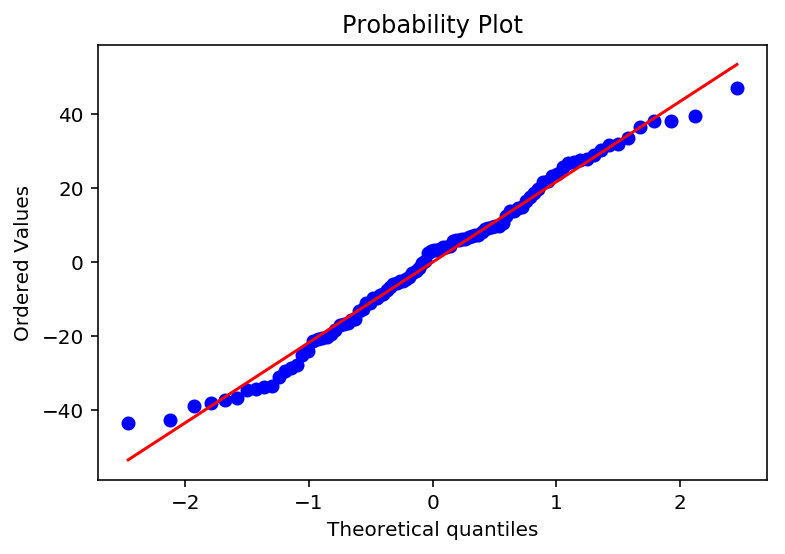

In [11]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [12]:
test = sms.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  3.523
P-value     :  0.172


In [13]:
test = sms.jarque_bera(result.resid)
for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test):
    print("%-12s: %6.3f" % xi)

Jarque-Bera :  2.059
P-value     :  0.357
Skew        : -0.073
Kurtosis    :  2.312


#### 3) 분포 확인

- 오차의 기댓값이 $x$와 상관없이 0이므로 잔차의 기댓값도 $x$와 상관없이 0

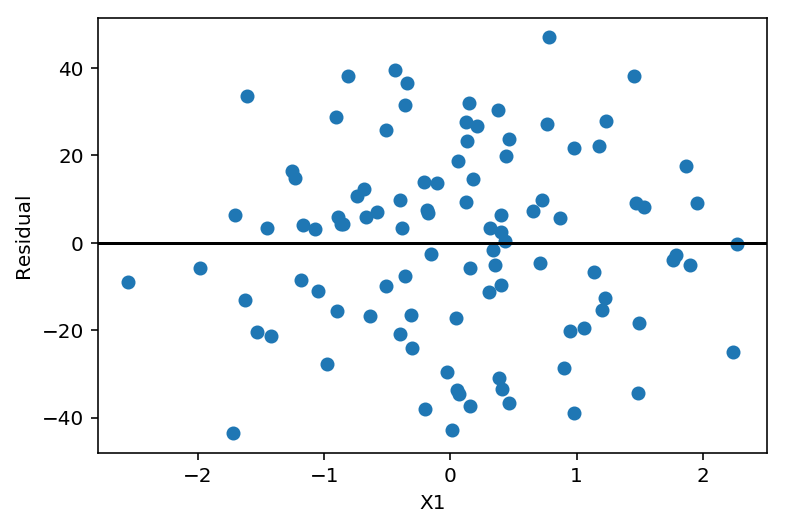

In [14]:
# x값이 달라짐에 따라 잔차의 분포가 어떻게 바뀌는 지를 살펴보기
plt.plot(X0, result.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("X1")
plt.ylabel("Residual")
plt.show()

$\rightarrow$ $x$값이 달라져도 분포의 형태가 크게 바뀌지 않음을 알 수 있음

- $0 < x < 1$인 구간과 $1 < x < 2$인 구간으로 나누어 분포의 모양을 살펴보기

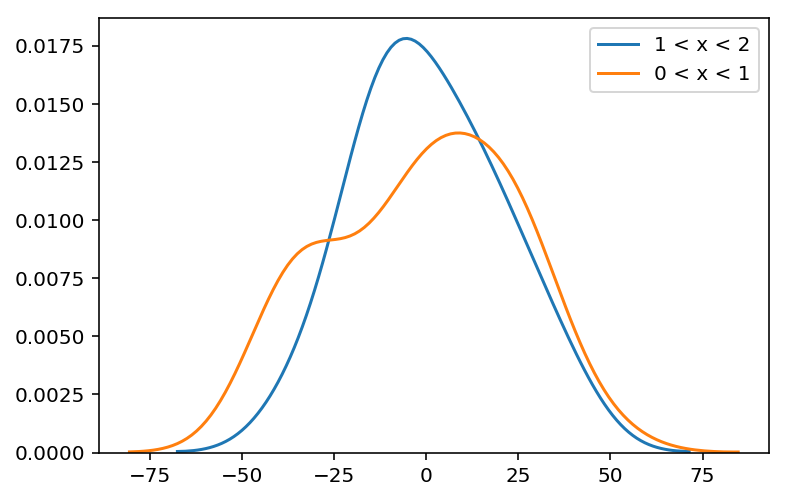

In [15]:
sns.kdeplot(result.resid[((1 < X0) & (X0 < 2)).flatten()], label="1 < x < 2") # 구간 1
sns.kdeplot(result.resid[((0 < X0) & (X0 < 1)).flatten()], label="0 < x < 1") # 구간 2
plt.legend()

plt.show()

$\rightarrow$ 둘 다 기댓값이 0에 가깝고 분산의 크기가 비슷함을 알 수 있음

---

### 05. 회귀 계수의 표준 오차

1) 가중치 $\hat{w}$ 도 정규 분포 확률 변수인 $y$의 선형 변환이므로 정규 분포를 따름

$$  
\begin{eqnarray}
\hat{w} 
&=& (X^TX)^{-1} X^T y \\\\
&=& (X^TX)^{-1} X^T (X w + \epsilon) \\\\
&=& w + (X^TX)^{-1} X^T \epsilon \\\\
\end{eqnarray}
$$

2) 가중치의 기댓값

$$  
\begin{eqnarray}
\text{E}[\hat{w}] 
&=&  \text{E}[ w + (X^TX)^{-1} X^T \epsilon ] \\\\
&=&  w + (X^TX)^{-1} X^T \text{E}[ \epsilon ] \\\\
&=& w
\end{eqnarray}
$$

3) 가중치의 (공)분산

$$
\begin{eqnarray}
\text{Cov}[\hat{w}] 
&=& E[(\hat{w} - w)(\hat{w} - w)^T] \\\\
&=& E[((X^TX)^{-1} X^T \epsilon)((X^TX)^{-1} X^T \epsilon)^T] \\\\
&=& E[(X^TX)^{-1} X^T \epsilon \epsilon^T X(X^TX)^{−1} ] \\\\
&=& (X^TX)^{-1} X^T E[\epsilon \epsilon^T] X(X^TX)^{−1} \\\\
&=& (X^TX)^{-1} X^T (\sigma^2 I) X(X^TX)^{−1} \\\\
&=& \sigma^2  (X^TX)^{-1}
\end{eqnarray}
$$



4) $\sigma^2$의 값은 알지 못하므로 추정해야 함

$$ s^2 = \dfrac{e^Te}{N-K} = \dfrac{RSS}{N-K},\;\;\ K = D + 1 $$

- $N$은 표본 데이터의 수, $K$는 모수의 갯수
- 바이어스 즉, y절편을 고려하는 선형 모형이라면 모수의 갯수는 입력 데이터의 차원의 수 $D$에 1을 더한 값

5) $\hat{w}$의 (공)분산의 추정값

$$ \text{Est.Cov}[\hat{w}]  = s^2(X^TX)^{-1}$$

6) 분산 행렬에서 우리가 관심을 가지는 값은 $w_i$의 분산을 뜻하는 대각 성분 (분산만 떼오기)

$$\text{Est.Var}[\hat{w}_i]  = \left( \text{Est.Cov}[\hat{w}] \right)_{ii} \;\; (i=0, \ldots, K-1)$$

7) 이 값에서 구한 표준 편차를 회귀 계수의 표준 오차(Standard Error of Regression Coefficient)라고 함

 $$ {se_i} = \sqrt{s^2 \big((X^TX)^{-1}\big)_{ii}} \;\; (i=0, \ldots, K-1)$$

$\rightarrow$ 모수 오차는 기댓값이 0이고 표준 오차를 분산으로 가지는 스튜던트-t 분포를 따름

---

### 06. 단일 계수 t-검정 (Single Coefficient t-test)

1) 정의 : $\hat{w}$을 위에서 구한 표준 오차로 나눈 값은 자유도가 $N-K$인 표준 스튜던트 t 분포를 따름

$$  \dfrac{\hat{w}_i - w_i}{se_i} \sim t_{N-K} \;\; (i=0, \ldots, K-1)$$

2) 검정 : 정의를 검정 통계량(test statistics)로 사용하면 특정 회귀 계수 $w_i$가 0 인지 아닌지에 대해 확인 가능

$$ H_0 : \;\; w_i = 0 \;\; (i=0, \ldots, K-1)$$

- 유의확률(p-value) ~ 0 : 귀무가설은 기각이므로 $w_i$ 값이 0일 가능성은 적음


- 유의확률(p-value) > 유의수준 : $w_i$ 값이 0일 가능성이 큼. 즉, 해당 독립변수는 종속변수와 아무런 상관성이 없을 가능성이 있음

3) 예시

In [16]:
# summary
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Sun, 04 Mar 2018   Prob (F-statistic):           2.21e-36
Time:                        08:28:17   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6284      2.163     -0.753      0.4

- std err : 모형계수의 표준오차
- t : 단일 계수 t-검정의 검정 통계량
- P>|t| : 유의확률

4) RegressionResults 클래스 객체는 t test 를 위한 t_test 메서드를 제공

In [17]:
# 계수 값이 0이 아닌 경우도 테스트
print(result.t_test("X1 = 40"))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            42.8534      2.142      1.332      0.186      38.603      47.104


$\rightarrow$ 위 예제에서 x1에 대한 계수값을 40으로 해도 되는지 테스트, 유의확률이 크기 때문에 귀무가설 채택함

---

### 07. F - 검정 (Loss-of-Fit 검정)

1) 정의 : 개별 개수가 아닌 전체 회귀 계수가 모두 의미가 있는지 확인하는 경우

$$ H_0 : w_0  = w_1 = \cdots = w_{K-1} = 0 $$

2) 의미

- 전체 독립 변수 중 어느 것도 의미를 가진 것이 없다는 뜻이다. 대부분의 경우, 이 귀무가설은 기각 (현실적으로)


- 그렇다면 이 검정은 어떤 의미가 있을까? 유의확률이 작을수록 더 의미있는 모형이라 판단함


- 따라서 여러 모형의 유의 확률을 비교하면서 어느 모형이 더 성능이 좋은가를 비교할 수 있음


- 이러한 귀무 가설을 검정하는 것을 회귀 분석 F-검정 (regression F-test) 또는 Loss-of-Fit 검정임

3) summary 에서 확인

- F-statistic: 400.3
- Prob (F-statistic) : 매우 작은 값이라는 것을 확인 ($2.21*10^-36$), 따라서 귀무가설 기각)